Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best hyperparameters found: {'alpha': 0.003593813663804626, 'l1_ratio': 0.30000000000000004}
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       306
           1       0.30      0.67      0.41        48

    accuracy                           0.74       354
   macro avg       0.62      0.71      0.62       354
weighted avg       0.85      0.74      0.78       354

Final AUC: 0.8097766884531591


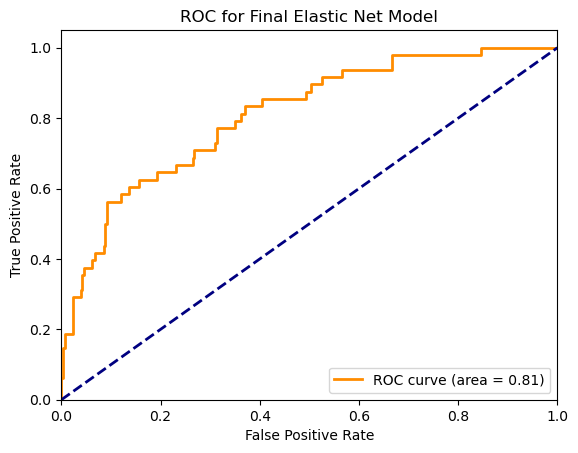

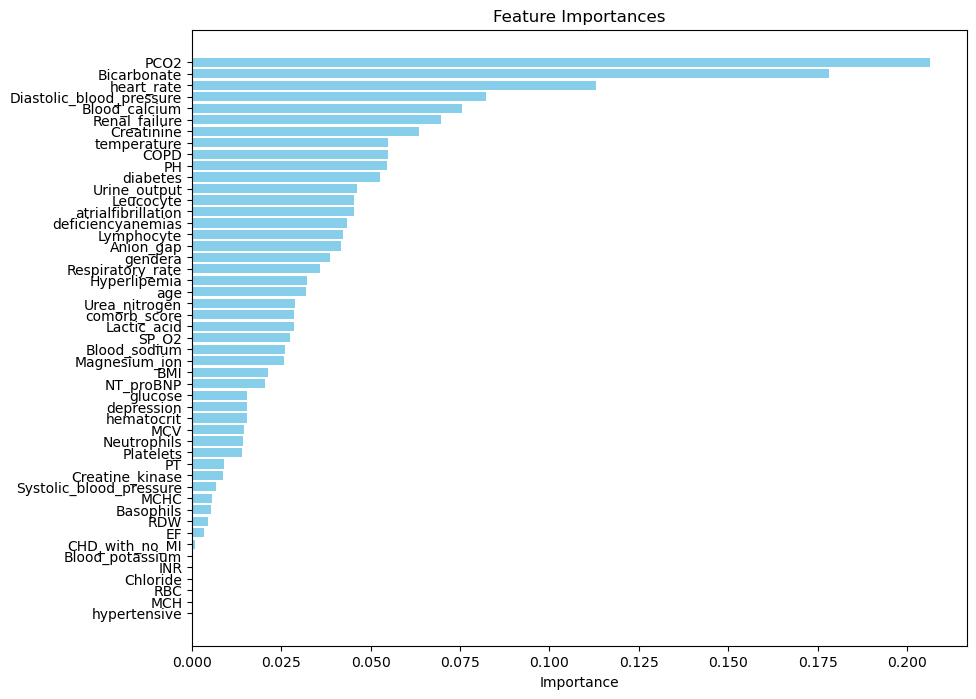

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed, stratify=data['outcome'])
    return train_data, valid_data

# Preprocess the data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed=42)

X_train = train_data[predictor_names].values
y_train = train_data['outcome'].values
X_valid = valid_data[predictor_names].values
y_valid = valid_data['outcome'].values

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the Elastic Net model
enet = ElasticNet(max_iter=100000)

# Define the hyperparameters to tune
param_grid = {
    'alpha': np.logspace(-3, 2, 10),  # More refined alpha range
    'l1_ratio': np.linspace(0.1, 0.9, 9)  # Exclude 0 to avoid Ridge-specific cases
}

# Perform GridSearchCV with stratified K-Folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=enet, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters found
best_enet = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)

# Train the final model with the best hyperparameters
best_enet.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model
y_pred_proba_final = best_enet.predict(X_valid)
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

print(classification_report(y_valid, y_pred_final, zero_division=0))

# Calculate AUC for the final model
auc_final = roc_auc_score(y_valid, y_pred_proba_final)
print(f"Final AUC: {auc_final}")

# Plot ROC curve for the final model
fpr_final, tpr_final, thresholds_final = roc_curve(y_valid, y_pred_proba_final)
plt.figure()
plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'ROC curve (area = {auc_final:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Final Elastic Net Model')
plt.legend(loc="lower right")
plt.show()

# Calculate feature importances
coefficients = best_enet.coef_
features = predictor_names

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


### bayesian lasso

In [36]:
import pymc as pm
import aesara.tensor as at
import pandas as pd

print("PyMC and Aesara are successfully imported.")





PyMC and Aesara are successfully imported.


Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best hyperparameters found: {'alpha': 0.003593813663804626, 'l1_ratio': 0.30000000000000004}
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       306
           1       0.30      0.67      0.41        48

    accuracy                           0.74       354
   macro avg       0.62      0.71      0.62       354
weighted avg       0.85      0.74      0.78       354

Final AUC: 0.8097766884531591


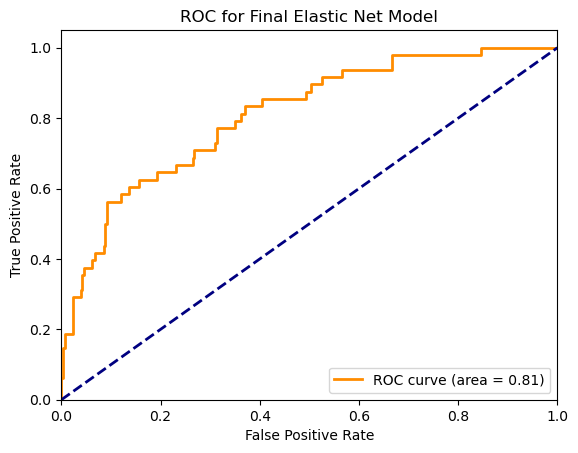

                     Feature  Importance
25                      PCO2    0.206447
3                Bicarbonate    0.178074
45                heart_rate    0.113108
12  Diastolic_blood_pressure    0.082226
4              Blood_calcium    0.075473
31             Renal_failure    0.069600
11                Creatinine    0.063635
48               temperature    0.054782
8                       COPD    0.054710
26                        PH    0.054456
42                  diabetes    0.052509
36              Urine_output    0.046260
17                 Leucocyte    0.045454
38        atrialfibrillation    0.045276
40         deficiencyanemias    0.043263
18                Lymphocyte    0.042301
0                  Anion_gap    0.041544
43                   gendera    0.038575
32          Respiratory_rate    0.035754
14              Hyperlipemia    0.032186


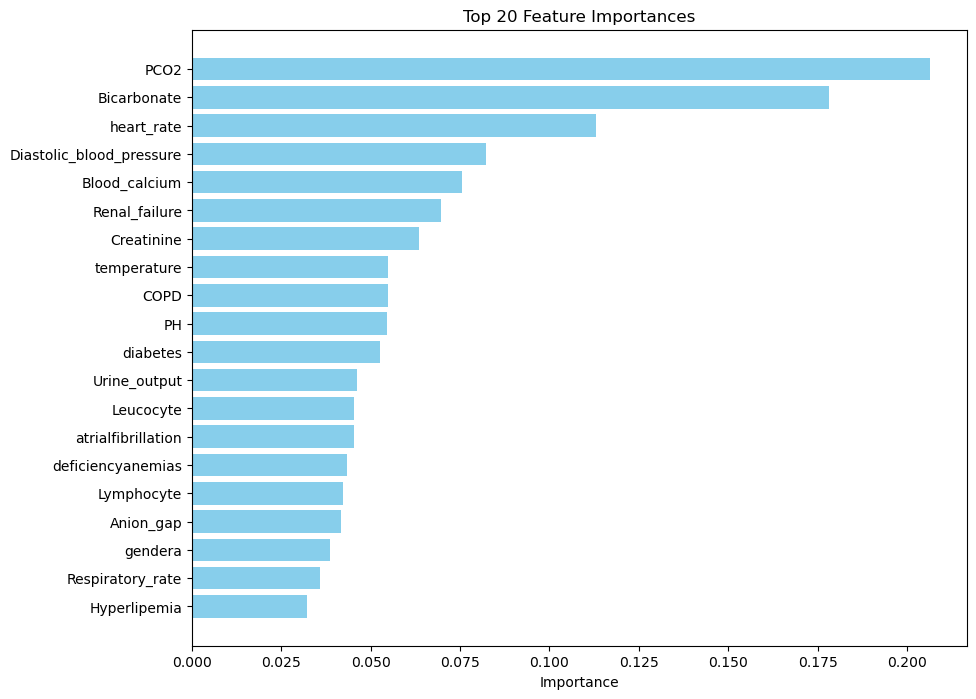

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed, stratify=data['outcome'])
    return train_data, valid_data

# Preprocess the data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed=42)

X_train = train_data[predictor_names].values
y_train = train_data['outcome'].values
X_valid = valid_data[predictor_names].values
y_valid = valid_data['outcome'].values

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the Elastic Net model
enet = ElasticNet(max_iter=100000)

# Define the hyperparameters to tune
param_grid = {
    'alpha': np.logspace(-3, 2, 10),  # More refined alpha range
    'l1_ratio': np.linspace(0.1, 0.9, 9)  # Exclude 0 to avoid Ridge-specific cases
}

# Perform GridSearchCV with stratified K-Folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=enet, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters found
best_enet = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)

# Train the final model with the best hyperparameters
best_enet.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model
y_pred_proba_final = best_enet.predict(X_valid)
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

print(classification_report(y_valid, y_pred_final, zero_division=0))

# Calculate AUC for the final model
auc_final = roc_auc_score(y_valid, y_pred_proba_final)
print(f"Final AUC: {auc_final}")

# Plot ROC curve for the final model
fpr_final, tpr_final, thresholds_final = roc_curve(y_valid, y_pred_proba_final)
plt.figure()
plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'ROC curve (area = {auc_final:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Final Elastic Net Model')
plt.legend(loc="lower right")
plt.show()

# Calculate feature importances
coefficients = best_enet.coef_
features = predictor_names

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})

# Sort the DataFrame by importance and select top 20 features
top_features_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Print the top 20 features
print(top_features_df)

# Plot feature importances of top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()


### Bootstrapping and Confidence Intervals

Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best hyperparameters found: {'alpha': 0.003593813663804626, 'l1_ratio': 0.30000000000000004}


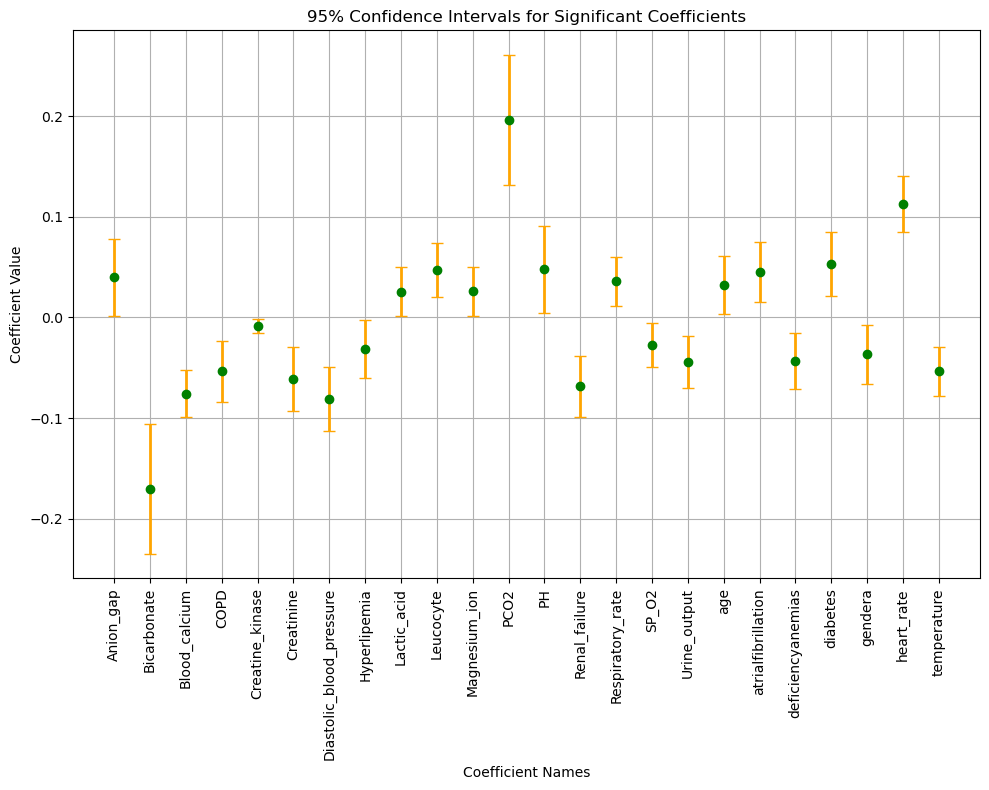

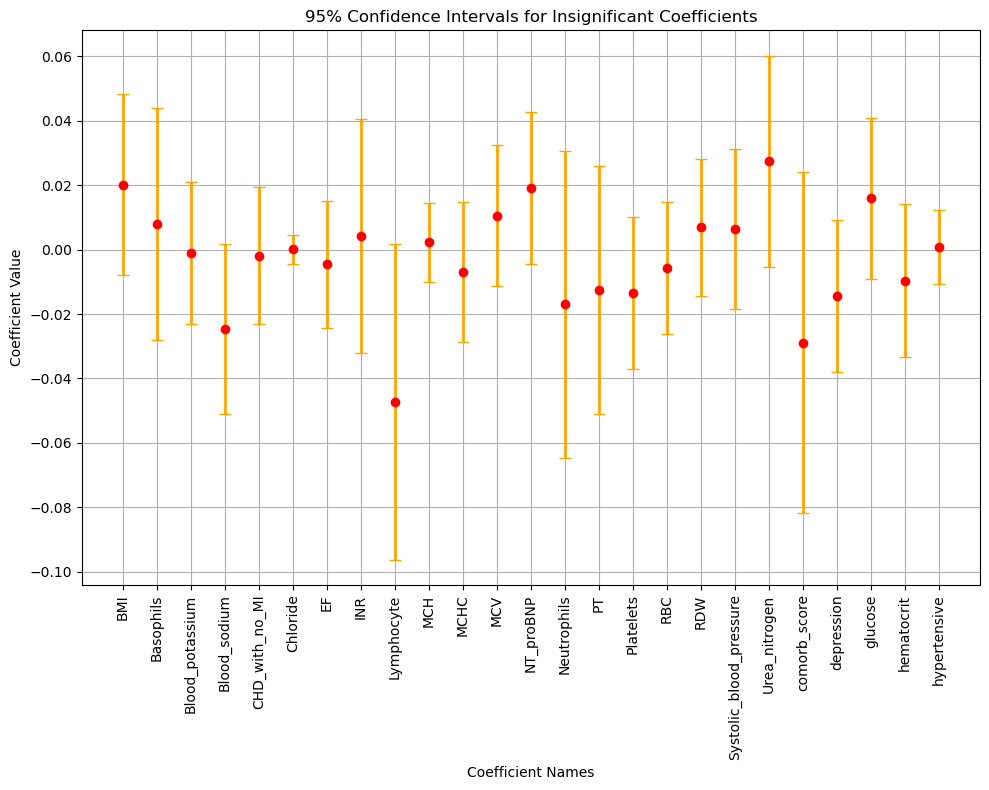

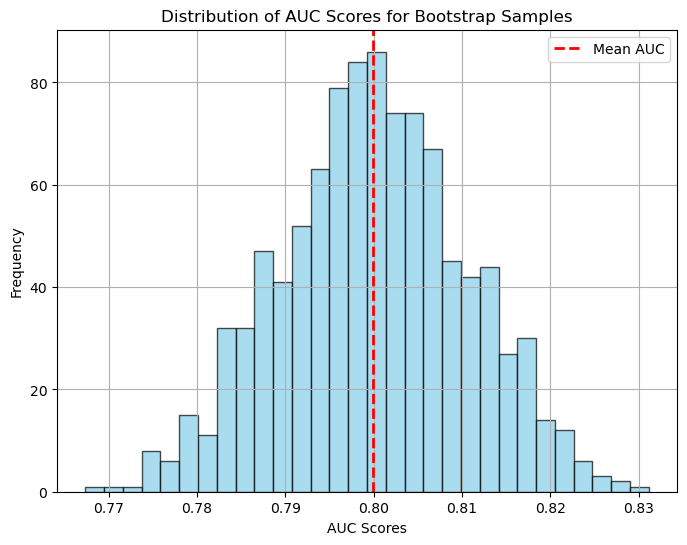

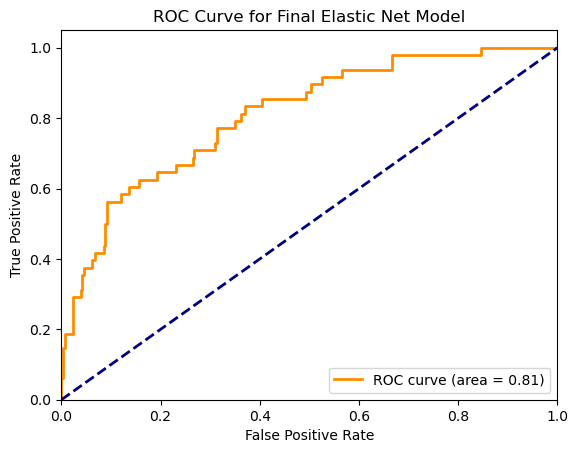

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import resample

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed, stratify=data['outcome'])
    return train_data, valid_data

# Preprocess the data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed=42)

X_train = train_data[predictor_names].values
y_train = train_data['outcome'].values
X_valid = valid_data[predictor_names].values
y_valid = valid_data['outcome'].values

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the Elastic Net model
enet = ElasticNet(max_iter=100000)

# Define the hyperparameters to tune
param_grid = {
    'alpha': np.logspace(-3, 2, 10),  # More refined alpha range
    'l1_ratio': np.linspace(0.1, 0.9, 9)  # Exclude 0 to avoid Ridge-specific cases
}

# Perform GridSearchCV with stratified K-Folds to find the best model
skf = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(estimator=enet, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters found
best_enet = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)

# Function to fit Elastic Net model on bootstrap samples
def fit_enet_bootstrap(X_train, y_train, alpha, l1_ratio):
    enet = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=100000)
    X_boot, y_boot = resample(X_train, y_train, replace=True)
    enet.fit(X_boot, y_boot)
    return enet

# Number of bootstrap samples
n_bootstrap = 1000

# Arrays to store coefficients and AUCs
coef_samples = []
auc_scores = []

# Bootstrap sampling loop
for _ in range(n_bootstrap):
    # Fit Elastic Net on bootstrap sample
    enet = fit_enet_bootstrap(X_train_resampled, y_train_resampled, **grid_search.best_params_)
    
    # Predict probabilities on validation set
    y_pred_proba = enet.predict(X_valid)
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_valid, y_pred_proba)
    auc_scores.append(auc_score)
    
    # Store coefficients
    coef_samples.append(enet.coef_)

# Compute confidence intervals for coefficients
coef_samples = np.array(coef_samples)
coef_means = np.mean(coef_samples, axis=0)
coef_std_errors = np.std(coef_samples, axis=0)
z_critical = 1.96  # for 95% confidence interval
lower_bound = coef_means - z_critical * coef_std_errors
upper_bound = coef_means + z_critical * coef_std_errors

# Separate significant and insignificant coefficients
significant_mask = (lower_bound > 0) | (upper_bound < 0)
insignificant_mask = ~significant_mask

significant_coef_names = predictor_names[significant_mask]
significant_coef_means = coef_means[significant_mask]
significant_coef_std_errors = coef_std_errors[significant_mask]

insignificant_coef_names = predictor_names[insignificant_mask]
insignificant_coef_means = coef_means[insignificant_mask]
insignificant_coef_std_errors = coef_std_errors[insignificant_mask]

# Plot significant coefficients
plt.figure(figsize=(10, 8))
plt.errorbar(significant_coef_names, significant_coef_means, yerr=1.96 * significant_coef_std_errors, fmt='o', color='green', ecolor='orange', elinewidth=2, capsize=4)
plt.xlabel('Coefficient Names')
plt.ylabel('Coefficient Value')
plt.title('95% Confidence Intervals for Significant Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot insignificant coefficients
plt.figure(figsize=(10, 8))
plt.errorbar(insignificant_coef_names, insignificant_coef_means, yerr=1.96 * insignificant_coef_std_errors, fmt='o', color='red', ecolor='orange', elinewidth=2, capsize=4)
plt.xlabel('Coefficient Names')
plt.ylabel('Coefficient Value')
plt.title('95% Confidence Intervals for Insignificant Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot AUC scores distribution
plt.figure(figsize=(8, 6))
plt.hist(auc_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=np.mean(auc_scores), color='red', linestyle='--', linewidth=2, label='Mean AUC')
plt.xlabel('AUC Scores')
plt.ylabel('Frequency')
plt.title('Distribution of AUC Scores for Bootstrap Samples')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC curve for the final Elastic Net model
fpr, tpr, thresholds = roc_curve(y_valid, best_enet.predict(X_valid))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_valid, best_enet.predict(X_valid)):0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Final Elastic Net Model')
plt.legend(loc="lower right")
plt.show()


Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best hyperparameters found: {'alpha': 0.003593813663804626, 'l1_ratio': 0.30000000000000004}


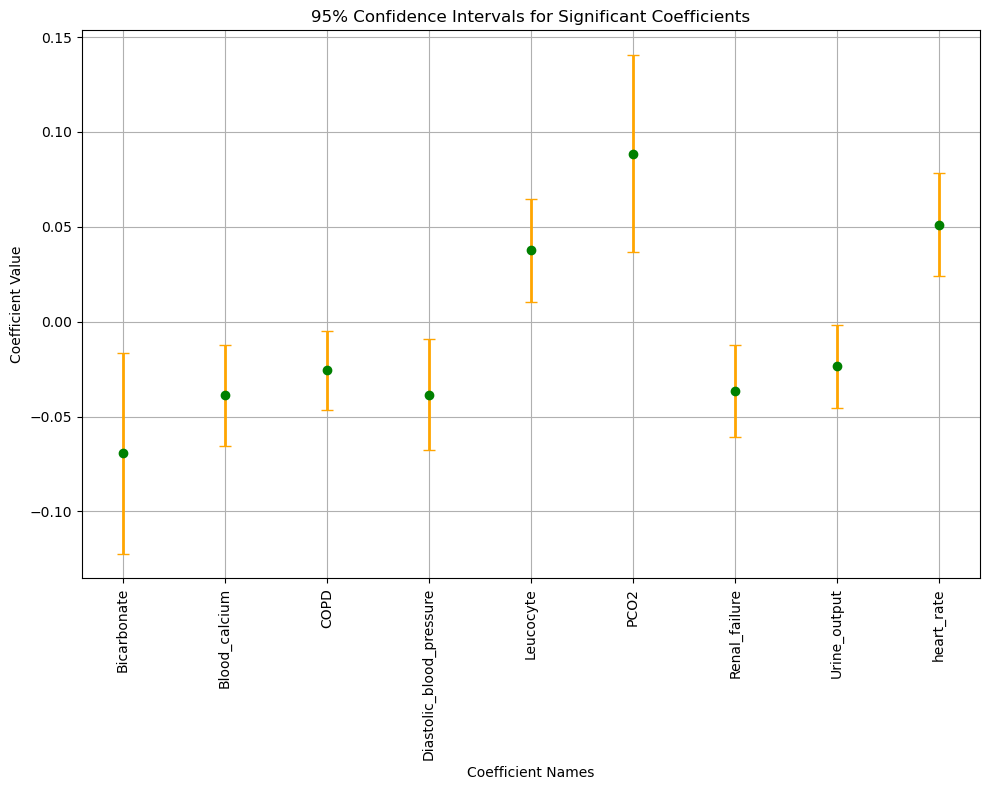

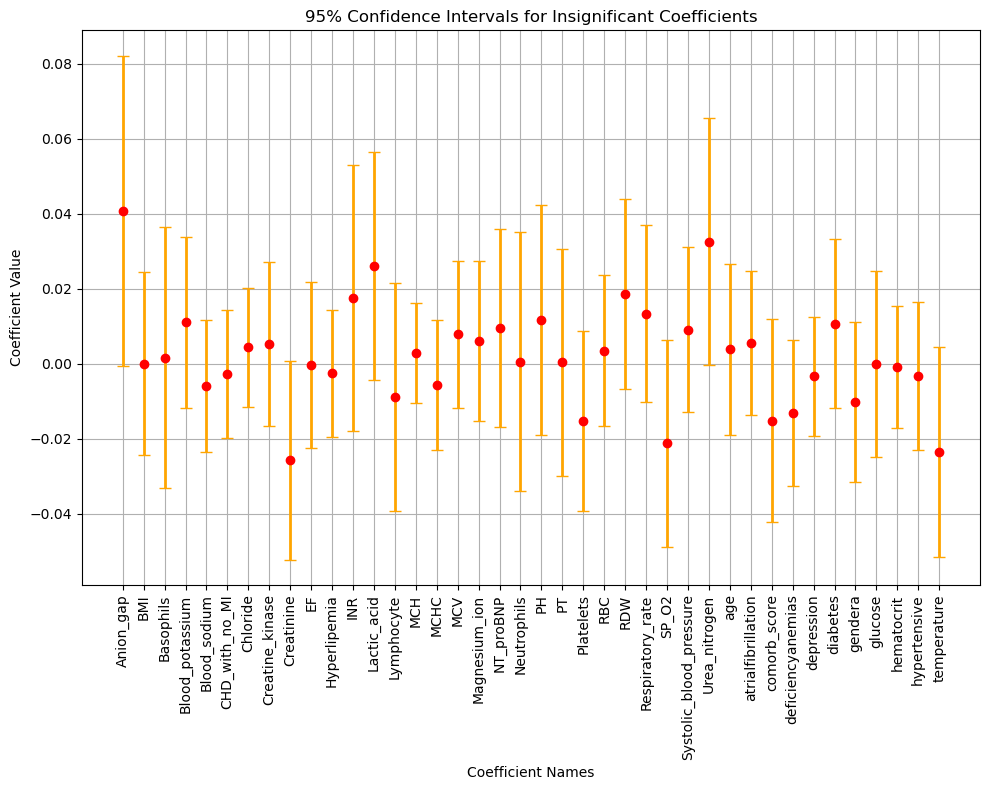

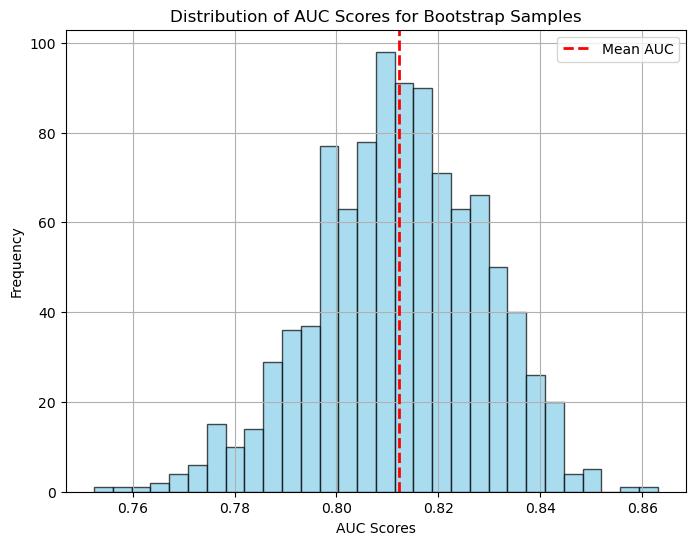

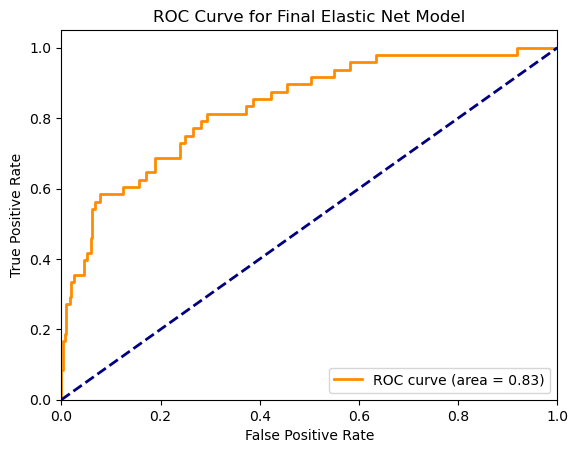

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import resample

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed, stratify=data['outcome'])
    return train_data, valid_data

# Preprocess the data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed=42)

X_train = train_data[predictor_names].values
y_train = train_data['outcome'].values
X_valid = valid_data[predictor_names].values
y_valid = valid_data['outcome'].values

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = X_train, y_train

# Define the Elastic Net model
enet = ElasticNet(max_iter=100000)

# Define the hyperparameters to tune
param_grid = {
    'alpha': np.logspace(-3, 2, 10),  # More refined alpha range
    'l1_ratio': np.linspace(0.1, 0.9, 9)  # Exclude 0 to avoid Ridge-specific cases
}

# Perform GridSearchCV with stratified K-Folds to find the best model
skf = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(estimator=enet, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters found
best_enet = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)

# Function to fit Elastic Net model on bootstrap samples
def fit_enet_bootstrap(X_train, y_train, alpha, l1_ratio):
    enet = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=100000)
    X_boot, y_boot = resample(X_train, y_train, replace=True)
    enet.fit(X_boot, y_boot)
    return enet

# Number of bootstrap samples
n_bootstrap = 1000

# Arrays to store coefficients and AUCs
coef_samples = []
auc_scores = []

# Bootstrap sampling loop
for _ in range(n_bootstrap):
    # Fit Elastic Net on bootstrap sample
    enet = fit_enet_bootstrap(X_train_resampled, y_train_resampled, **grid_search.best_params_)
    
    # Predict probabilities on validation set
    y_pred_proba = enet.predict(X_valid)
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_valid, y_pred_proba)
    auc_scores.append(auc_score)
    
    # Store coefficients
    coef_samples.append(enet.coef_)

# Compute confidence intervals for coefficients
coef_samples = np.array(coef_samples)
coef_means = np.mean(coef_samples, axis=0)
coef_std_errors = np.std(coef_samples, axis=0)
z_critical = 1.96  # for 95% confidence interval
lower_bound = coef_means - z_critical * coef_std_errors
upper_bound = coef_means + z_critical * coef_std_errors

# Separate significant and insignificant coefficients
significant_mask = (lower_bound > 0) | (upper_bound < 0)
insignificant_mask = ~significant_mask

significant_coef_names = predictor_names[significant_mask]
significant_coef_means = coef_means[significant_mask]
significant_coef_std_errors = coef_std_errors[significant_mask]

insignificant_coef_names = predictor_names[insignificant_mask]
insignificant_coef_means = coef_means[insignificant_mask]
insignificant_coef_std_errors = coef_std_errors[insignificant_mask]

# Plot significant coefficients
plt.figure(figsize=(10, 8))
plt.errorbar(significant_coef_names, significant_coef_means, yerr=1.96 * significant_coef_std_errors, fmt='o', color='green', ecolor='orange', elinewidth=2, capsize=4)
plt.xlabel('Coefficient Names')
plt.ylabel('Coefficient Value')
plt.title('95% Confidence Intervals for Significant Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot insignificant coefficients
plt.figure(figsize=(10, 8))
plt.errorbar(insignificant_coef_names, insignificant_coef_means, yerr=1.96 * insignificant_coef_std_errors, fmt='o', color='red', ecolor='orange', elinewidth=2, capsize=4)
plt.xlabel('Coefficient Names')
plt.ylabel('Coefficient Value')
plt.title('95% Confidence Intervals for Insignificant Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot AUC scores distribution
plt.figure(figsize=(8, 6))
plt.hist(auc_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=np.mean(auc_scores), color='red', linestyle='--', linewidth=2, label='Mean AUC')
plt.xlabel('AUC Scores')
plt.ylabel('Frequency')
plt.title('Distribution of AUC Scores for Bootstrap Samples')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC curve for the final Elastic Net model
fpr, tpr, thresholds = roc_curve(y_valid, best_enet.predict(X_valid))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_valid, best_enet.predict(X_valid)):0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Final Elastic Net Model')
plt.legend(loc="lower right")
plt.show()
